# PAC Part

**Step1: Data Preprocessing**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from matplotlib.pylab import rcParams
from pandas.core import datetools
rcParams['figure.figsize'] = 15, 7
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import  stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\zinaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


In [52]:
##################################################
#               LOAD DATA                        #
##################################################
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H')

train04_series = pd.read_csv('BATADAL_dataset04.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
# print(train04_series.shape)#(4177, 44)
# train04_series = train04_series.resample('D').mean()
# print(train04_series.shape)#(175, 44)
train04_series = train04_series.fillna(train04_series.bfill())
# print(train04_series.shape)#(175, 44)
X_train04 = train04_series.drop('ATT_FLAG',axis=1,inplace=False)
y_train04 = train04_series['ATT_FLAG']

train03_series = pd.read_csv('BATADAL_dataset03.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
# print(train03_series.shape)# (8761, 44)
# train03_series = train03_series.resample('D').mean()
# print(train03_series.shape)# (366, 44)
X_train03 = train03_series.drop('ATT_FLAG',axis=1,inplace=False)
y_train03 = train03_series['ATT_FLAG']

test_set = pd.read_csv('BATADAL_test_dataset_label.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
y_test= test_set['AUU_FLAG']
# test_set = test_set.resample('D').mean()
# print(X_train03.index, test_set.index)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler03 = StandardScaler().fit(X_train03)
X_train_nom03 = scaler03.transform(X_train03)
#print 'mean:',X_train_nom.mean(axis=0) #inspect the mean and the variance
#print 'variance:', X_train_nom.std(axis=0)
scaler04 = StandardScaler().fit(X_train04)
X_train_nom04 = scaler04.transform(X_train04)

In [7]:
# function of deciding the number of eigenvalue to use for PCA
def percentage2n(eigVals,percentage):  
    sortArray=np.sort(eigVals)   
    sortArray=sortArray[-1::-1]   
    arraySum=sum(sortArray)  
    tmpSum=0  
    num=0  
    for i in sortArray:  
        tmpSum+=i  
        num+=1  
        if tmpSum>=arraySum*percentage:  
            return num,sortArray

In [11]:
# find the number of eigenvalue
covMat03=np.cov(X_train_nom03,rowvar=0)
eigVals03,eigVects03=np.linalg.eig(np.mat(covMat03)) 
num03,sortArray03 = percentage2n(eigVals03,0.90)
print ('Number of principle component of training set 03:',num03)  
print ('array of eigenvalue:',sortArray03)        # variance


covMat04=np.cov(X_train_nom04,rowvar=0)
eigVals04,eigVects04=np.linalg.eig(np.mat(covMat04)) 
num04,sortArray04 = percentage2n(eigVals04,0.95)
print ('Number of principle component of training set 04:',num04)
print ('array of eigenvalue:',sortArray04)        # variance
num03 = 36
num04 = 36

Number of principle component of training set 03: 10
array of eigenvalue: [7.73880163e+00 4.81738519e+00 4.60975503e+00 3.59198956e+00
 2.59716191e+00 2.43398357e+00 1.99933262e+00 1.99388799e+00
 1.53114630e+00 1.16955790e+00 9.23926257e-01 8.84997095e-01
 6.71067185e-01 5.43107776e-01 2.63363186e-01 1.04771232e-01
 3.93624696e-02 2.83612156e-02 2.38967620e-02 1.46386292e-02
 9.12329242e-03 7.42142144e-03 2.42577247e-03 1.91759825e-03
 1.01347477e-03 5.44403134e-04 3.05990281e-04 2.96699289e-04
 1.98771459e-04 1.95000329e-04 1.12080398e-04 6.04850875e-05
 1.04826088e-06 2.35440435e-08 8.64833738e-10 2.50102089e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Number of principle component of training set 04: 13
array of eigenvalue: [7.31641152e+00 4.75097933e+00 4.66254272e+00 3.47832835e+00
 2.66987990e+00 2.50756422e+00 2.01049800e+00 1.90089649e+00
 1.54088539e+00 1.16987464e+00 9.10333475e-01 8.99335139e-01
 7.09421029e

In [12]:
# define the function of PCA. return the reconstructed data and principle eigenvectors.
def pca(newData,n):   
    covMat=np.cov(newData,rowvar=0)    #calculate covariance matrix  
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))  
    eigValIndice=np.argsort(eigVals)             
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]    
    n_eigVect=eigVects[:,n_eigValIndice]         
    lowDDataMat=newData*n_eigVect                
    reconMat=(lowDDataMat*n_eigVect.T)  #reconstructed data 
    return n_eigVect,reconMat

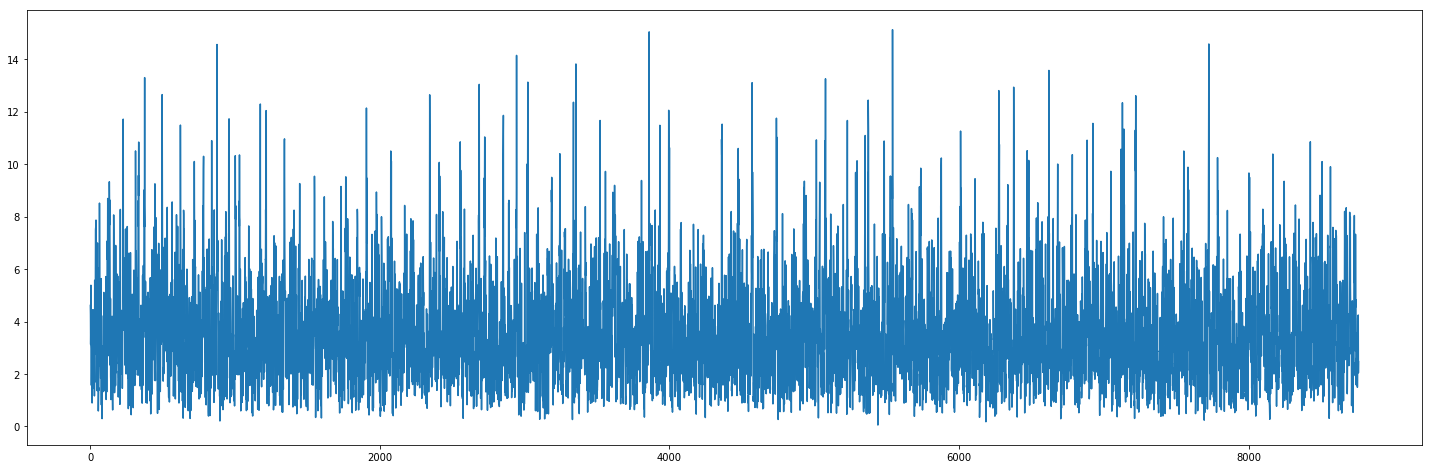

In [23]:
P03,X_train_rec03 = pca(X_train_nom03,num03)
residual_pca1_03  = X_train_nom03 - X_train_rec03
residual_pca2_03 = np.square(residual_pca1_03)
residual_pca_03 = residual_pca2_03.sum(axis=1) 
figure, ax = plt.subplots(figsize=[25,8])
plt.figure(figsize=[25,8])
ax.plot(residual_pca_03)

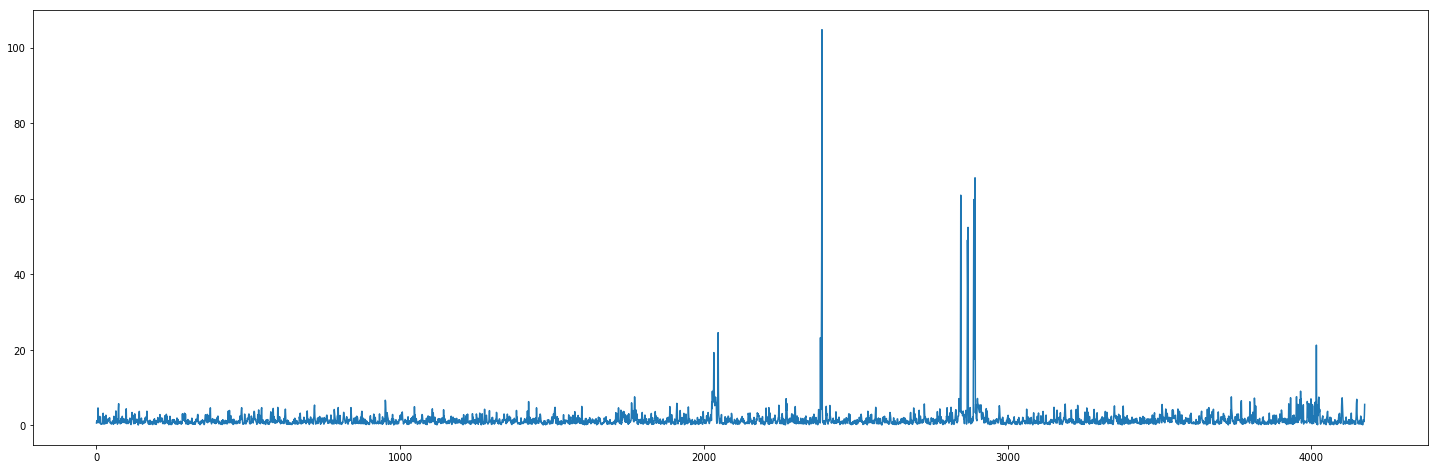

In [30]:
P04,X_train_rec04 = pca(X_train_nom04,num04)
residual_pca1_04  = X_train_nom04 - X_train_rec04
residual_pca2_04 = np.square(residual_pca1_04)
residual_pca_04 = residual_pca2_04.sum(axis=1) 
figure, ax = plt.subplots(figsize=[25,8])
# plt.axhline(y=15,color = 'r')
ax.plot(residual_pca_04)
plt.figure(figsize=[25,8])


In [27]:
#calculate the threshold, according to the paper "Diagnosing Network-Wide Traffic Anomalies"
lambda1_03 = sortArray03
lambda2_03 = np.power(sortArray03,2)
lambda3_03 = np.power(sortArray03, 3)

fi1_03 = sum(lambda1_03[num03:])
fi2_03 = sum(lambda2_03[num03:])
fi3_03 = sum(lambda3_03[num03:])
h0_03 = 1-2.0*fi1_03*fi3_03 /(3*(fi2_03**2))
Ca_03=2.99
threshold_03 = fi1_03 * np.power(1.0 * Ca_03 * np.sqrt(2* fi2_03 * (h0_03 ** 2)) / fi1_03
                           + 1 + 1.0 * fi2_03 * h0_03 * (h0_03-1) / (fi1_03 ** 2) , 1.0 / h0_03)
print ((fi1_03,fi2_03,fi3_03),h0_03,threshold_03)

(3.5211078690564497, 2.4657825670073494, 1.9637670487247219) 0.2418267043564276 14.992186948534664


In [28]:
#calculate the threshold, according to the paper "Diagnosing Network-Wide Traffic Anomalies"
lambda1_04 = sortArray04
lambda2_04 = np.power(sortArray04,2)
lambda3_04 = np.power(sortArray04, 3)

fi1_04 = sum(lambda1_04[num04:])
fi2_04 = sum(lambda2_04[num04:])
fi3_04 = sum(lambda3_04[num04:])
h0_04= 1-2.0*fi1_04*fi3_04 /(3*(fi2_04**2))
Ca_04=2.99
threshold_04 = fi1_04 * np.power(1.0 * Ca_04 * np.sqrt(2* fi2_04 * (h0_04 ** 2)) / fi1_04
                           + 1 + 1.0 * fi2_04 * h0_04 * (h0_04-1) / (fi1_04 ** 2) , 1.0 / h0_04)
print ((fi1_04,fi2_04,fi3_04),h0_04,threshold_04)

(1.4816704917114745, 0.48822680915011696, 0.22472006569430558) 0.06876566748160906 7.993331919688504


percentage of Abnormal data in training data: [[0.00574575]]


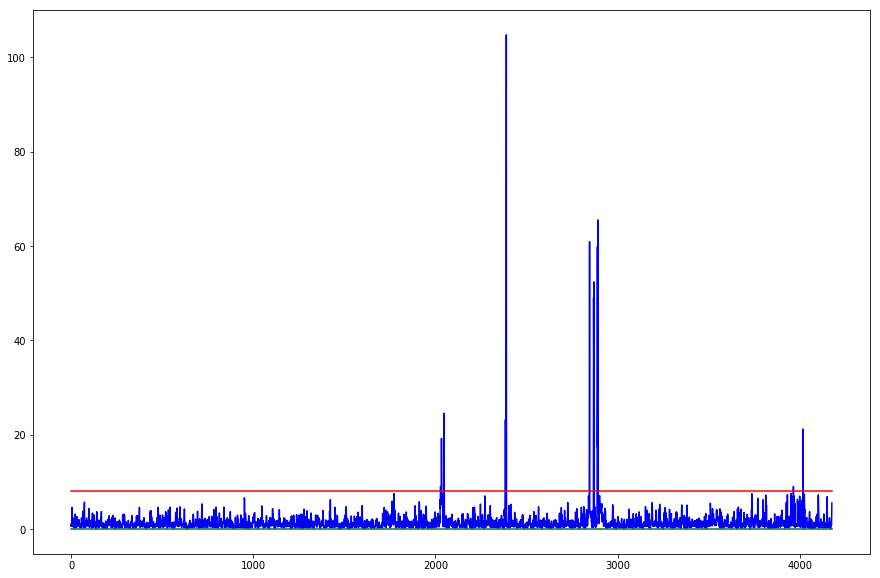

In [29]:
residual_pca1_04 = X_train_nom04 - X_train_rec04
residual_pca2_04 = np.square(residual_pca1_04)
residual_pca_04 = residual_pca2_04.sum(axis=1) 

figure, ax = plt.subplots(figsize=[15,10])
plt.figure(figsize=[25,10])
ax.plot(residual_pca_04,'b')
ax.plot([0,len(residual_pca_04)],[threshold_04,threshold_04],'r')
ax.plot([0,len(residual_pca_04)],[0.009,0.009],'g')
print ('percentage of Abnormal data in training data:', 1.0 * sum(residual_pca_04>threshold_04)/len(residual_pca_04))

(0, 1.0)

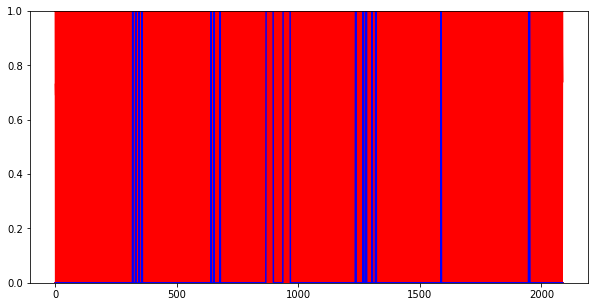

In [43]:
#test
X_test_nom04 = scaler04.transform(test_set) # apply the same normalization with training data
lowDDataMat_test04=X_test_nom04*P04      # apply the same pca with training data
reconMat_test04=(lowDDataMat_test04*P04.T)
residual_test1_04 = X_test_nom04-reconMat_test04
residual_test2_04 = np.square(residual_test1_04)
residual_test_04 = residual_test2_04.sum(axis=1) 

figure, ax = plt.subplots(figsize=[10,5])
ax.plot(1*test_set.values,'r')# plot the true label
ax.plot((residual_test_04)>threshold_04,'b')# plot the predicted label
plt.ylim(0,1.0)


In [48]:
residual_test_04 = np.array(residual_test_04).reshape([1,2089])[0]

In [49]:
predict_y = residual_test_04 > threshold_04

In [61]:
tp = sum(predict_y[y_test.values==1]==1)
print ('TP:',tp)
fp = sum((y_test.values - predict_y)==-1000)
print ('FP:',fp)
tn = sum(predict_y[y_test.values==-999]==-999)
print ('TN:',tn)
fn = sum(predict_y[y_test.values==-999]==1)
print ('FN:',fn)
print ('precision:' ,1.0 * tp/(tp+fp))
print ('recall:' ,1.0 * tp/(tp+fn))

TP: 407
FP: 1682
TN: 0
FN: 1682
precision: 0.1948300622307324
recall: 0.1948300622307324


In [60]:
residual_test = np.array(residual_test_04).reshape([1,2089])[0]
threshold_1 = 0.009
predict_y = residual_test > threshold_1
tp = sum(predict_y[y_test.values==-999]==-999)
print ('TP:',tp)
fp = sum(predict_y[y_test.values==1]==-999)
print ('FP:',fp)
tn = sum(predict_y[y_test.values==1]==1)
print ('TN:',tn)
fn = sum(predict_y[y_test.values==-999]==1)
print ('FN:',fn)

print ('precision:' ,1.0 * tp/(tp+fp))
print ('recall:' ,1.0 * tp/(tp+fn))

TP: 0
FP: 0
TN: 407
FN: 1682
precision: nan
recall: 0.0


C:\Users\zinaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
